In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from gurobipy import *
import osmnx as ox
ox.config(use_cache=True, log_console=True)
import math as math
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Candiates from FLM
# 27352149	49.811422	9.981127
# 27457548	49.791321	9.953342
# 27489160	49.785592	9.930666
# 30747843	49.773391	9.923226
# 40430241	49.800460	9.951607
# 41821495	49.779512	9.945042
# 41891143	49.723143	9.965097
# 113931550	49.817472	9.966234
# 119789584	49.798763	9.926746
# 148745753	49.811762	9.920440
# 251053298	49.760117	9.938963
# 259846165	49.737625	9.959138
# 266382498	49.762149	9.946778
# 269543881	49.825168	9.923331
# 567026710	49.798812	9.943050
# 600161921	49.794180	9.909960
# 1243381715 49.801487	9.980712
# 2054183844 49.792280	10.000277
# 4294196112 49.808323	9.886186
# 5315548501 49.785241	9.968157

In [2]:
# Number of Candidate DCs chosen from Facility Location Model
DC_N = 5

# List Creator for DCs
def createList_DC(r1, r2):
    return list(['DC%d'%x for x in range(r1, r2+1)])

#create an index
DC_ID = createList_DC(1, DC_N)

#Gi = fixed cost for establishing depot i
fixed_cost_DC = [150] * DC_N 

#Maximum Throughput at depot i = Vi
capacity_DC = [100] * DC_N

#Variable Warehousing Cost (Picking)
varCost_DC = [0.5, 0.4, 0.2, 0.8]

#Position of the DCs
lat_DC = [49.7682755, 49.7326234, 49.8113122, 49.7979646, 49.8109994]
lon_DC = [9.9394726, 9.9649484, 9.920716, 9.9426957, 9.9777457]

# Osmid of the Dcs
osmid = [36720636, 41891228, 148745748, 33171211, 21288066]

dc_tuples = list(zip(DC_ID, fixed_cost_DC, capacity_DC, varCost_DC, lat_DC, lon_DC, osmid))

set_of_all_DC = pd.DataFrame(dc_tuples, columns = ["DC_ID", "fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon", "osmid"])
set_of_all_DC.set_index("DC_ID", inplace = True)

# Define Index I for model building
I = set_of_all_DC.index.values

# DC_S
DC_S = set_of_all_DC["osmid"].values.tolist()

set_of_all_DC

,fixed_cost_DC,capacity_DC,varCost_DC,lat,lon,osmid
DC_ID,,,,,,
DC1,150,100,0.5,49.768276,9.939473,36720636
DC2,150,100,0.4,49.732623,9.964948,41891228
DC3,150,100,0.2,49.811312,9.920716,148745748
DC4,150,100,0.8,49.797965,9.942696,33171211


In [3]:
# Sample Customers from osmnx

# Define Customer N and Demand per
customers = 25
demand_per_customer = 5

# Function to create a Customer Index List
def createList_C(r1, r2):
    return list(['C%d'%x for x in range(r1, r2+1)])

# Get all nodes in Würzburg from OSMNX which will be used to sample a certain amount of customers
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Gs)

# Create nodes_df which is the basis for our customer df
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]

#Sample from nodes_df
samp_first = nodes_df.sample(n= 190, random_state = 3)

sample_nodes_df = samp_first.sample(n = customers, random_state= 3)


#DF Manipulation
C_ID = createList_C(1,customers)
osmid = list(sample_nodes_df.index.values)
sample_nodes_df = sample_nodes_df.rename(index=dict(zip(osmid,C_ID)))
sample_nodes_df.index.name = "C_ID"
sample_nodes_df["osmid"] = osmid

#Create final demand column for customer DF
mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
# Add Demand column from the newly created list
set_of_all_customers['Demand_C'] = mylist
# Sort the df by osmid, this needs to be done for renaming purposes in the dist_matrix
set_of_all_customers = set_of_all_customers.sort_values(by=["osmid"])
# New index C1-C2 etc.
set_of_all_customers.reset_index(drop=True, inplace=True)
set_of_all_customers.index = C_ID
set_of_all_customers.index.names = ["C_ID"]
# Create Nodes_S for joining and plotting later
Nodes_S = set_of_all_customers["osmid"].tolist()
# Create index J for model building
J = set_of_all_customers.index.values
set_of_all_customers.head()

,lat,lon,osmid,Demand_C
C_ID,,,,
C1,49.773391,9.923226,30747843,5
C2,49.787978,9.960577,41822006,5
C3,49.793691,9.952511,42411608,5
C4,49.786099,9.945155,51514876,5
C5,49.794972,9.957999,51519006,5


In [4]:
Nodes_S = set_of_all_customers["osmid"].tolist()
Nodes_S1 = DC_S + Nodes_S
# By combining the lists in this way, the DCs are first and customers second
#Nodes_S1

In [5]:
# Construct set of all vehicles K

#Vehicle Count
V_N = 5

# Vehicle List Creator
def createList_V(r1, r2):
    return list(['V_%d'%x for x in range(r1, r2+1)])

# create index
V_ID = createList_V(1, V_N)

# Vehicle Capacity Qk
capacity_V = [50] * V_N

# fixed cost of using Vehicle Fk
fixed_cost_V = [5] * V_N

v_tuples = list(zip(V_ID, capacity_V, fixed_cost_V))

set_of_all_vehicles = pd.DataFrame(v_tuples, columns = ["V_ID", "capacity_V", "fixed_cost_V"])
set_of_all_vehicles.set_index("V_ID", inplace=True)
K = set_of_all_vehicles.index.values
set_of_all_vehicles

,capacity_V,fixed_cost_V
V_ID,,
V_1,50,5
V_2,50,5
V_3,50,5
V_4,50,5
V_5,50,5


In [6]:
# Create full Distance Matrix from which we can sample the Customers/PuPs
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
mat_generator = nx.all_pairs_dijkstra_path_length(Gs, weight = "length")
mat_dict = dict(mat_generator)
mat = pd.DataFrame(mat_dict).round(1)
mat = mat.rename_axis("osmid").sort_values(by = ["osmid"])
mat.head()

,10799058,10799066,10799083,10799085,10799087,10799937,10799942,10799945,10799947,10799949,...,8684424129,8917651907,8917667635,8917667643,8917704467,8917704493,8917704495,8917704496,8917704497,8981470540
osmid,,,,,,,,,,,,,,,,,,,,,
10799058,0.0,4595.5,93.1,650.3,389.9,2857.6,3326.5,3247.3,3233.5,3263.2,...,5808.1,10274.0,10505.1,10563.3,6711.6,6754.4,6745.1,6752.8,6765.9,5583.3
10799066,470.5,0.0,412.6,323.3,709.4,3177.1,3646.0,3566.8,3553.0,3582.8,...,6127.6,10593.5,10824.6,10882.8,7031.1,7073.9,7064.6,7072.3,7085.4,5902.8
10799083,704.3,4502.4,0.0,557.2,296.8,2764.5,3233.4,3154.2,3140.4,3170.1,...,5715.0,10180.9,10412.0,10470.2,6618.5,6661.3,6652.0,6659.7,6672.8,5490.2
10799085,147.2,4591.7,89.3,0.0,386.1,2853.8,3322.6,3243.4,3229.7,3259.4,...,5804.3,10270.2,10501.2,10559.5,6707.8,6750.6,6741.3,6749.0,6762.1,5579.5
10799087,4676.1,4205.6,4618.2,4528.9,0.0,2467.7,2936.5,2857.4,2843.6,2873.3,...,5418.2,9884.1,10115.1,10173.4,6321.7,6364.5,6355.2,6362.9,6376.0,5193.4


In [7]:
# Join Distances for the sampled nodes from our Initial Distance Matrix for all nodes 
dist_matrix_d = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the distance matrix
dist_matrix_d = dist_matrix_d.rename_axis("osmid")
# Join new empty dist_matrix with filled matrix for every chosen node
dist_matrix_d = dist_matrix_d.merge(mat, left_index=True, right_index=True)
dist_matrix_d = dist_matrix_d[dist_matrix_d.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
dist_matrix_d = dist_matrix_d.reindex(columns=Nodes_S1)

# Have to replace column names and index values with more paletable values (osmids could confuse, need DC1 C1 etc.). Use the I and J arrays from Customer and DC Dataframes to form a list
nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
dist_matrix_d.columns = new_colnames
dist_matrix_d.index = new_colnames
dist_matrix_d.head()

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,5194.6,8942.3,4394.8,1804.1,4054.0,4099.5,3128.1,4387.6,7660.2,...,4424.1,4990.9,7515.2,6030.5,7460.7,2743.3,7738.2,5217.4,9345.8,8229.3
DC2,5266.1,0.0,13856.9,9309.3,6718.6,8968.5,9014.0,8042.7,9302.2,12574.8,...,999.5,9905.4,12429.8,10945.1,12375.3,7266.4,12652.7,10132.0,14260.3,13143.8
DC3,8627.2,13821.9,0.0,5524.3,7907.3,7202.6,6255.4,7153.9,6879.8,7047.4,...,13051.3,5113.4,7705.9,4775.1,6274.2,9503.7,1237.7,3823.0,403.4,7616.5
DC4,3871.2,9065.8,5555.7,0.0,4105.7,2200.4,1606.4,1809.9,2104.2,4098.9,...,8295.3,596.1,3980.3,2353.4,3852.5,5702.0,4846.4,2325.6,5152.3,4667.9
C1,1534.5,6729.1,7952.8,4343.4,0.0,4891.9,4436.2,3593.3,4934.0,7973.3,...,5958.5,4827.9,7851.9,6343.6,7773.8,2410.9,6748.6,4227.9,8356.2,8542.3


In [8]:
# Cost Factor Multiplication. Each Meter of Route has a certain cost
dist_matrix = dist_matrix_d * 0.0003
dist_matrix.head()

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.00000,1.55838,2.68269,1.31844,0.54123,1.21620,1.22985,0.93843,1.31628,2.29806,...,1.32723,1.49727,2.25456,1.80915,2.23821,0.82299,2.32146,1.56522,2.80374,2.46879
DC2,1.57983,0.00000,4.15707,2.79279,2.01558,2.69055,2.70420,2.41281,2.79066,3.77244,...,0.29985,2.97162,3.72894,3.28353,3.71259,2.17992,3.79581,3.03960,4.27809,3.94314
DC3,2.58816,4.14657,0.00000,1.65729,2.37219,2.16078,1.87662,2.14617,2.06394,2.11422,...,3.91539,1.53402,2.31177,1.43253,1.88226,2.85111,0.37131,1.14690,0.12102,2.28495
DC4,1.16136,2.71974,1.66671,0.00000,1.23171,0.66012,0.48192,0.54297,0.63126,1.22967,...,2.48859,0.17883,1.19409,0.70602,1.15575,1.71060,1.45392,0.69768,1.54569,1.40037
C1,0.46035,2.01873,2.38584,1.30302,0.00000,1.46757,1.33086,1.07799,1.48020,2.39199,...,1.78755,1.44837,2.35557,1.90308,2.33214,0.72327,2.02458,1.26837,2.50686,2.56269


In [9]:
mat1 = pd.read_hdf("time_matrix_wue_200.h5", "final_df")
mat1

,283531080,1312952369,258899345,28338982,41891309,36720636,41891228,148745748,33171211,21288066,...,4574059744,4914899889,5301313588,5315548501,5409647214,6034416208,6533691138,6895353620,6905414381,8321645412
osmid,,,,,,,,,,,,,,,,,,,,,
283531080,0,1039,1778,1159,1100,913,955,1192,1091,1268,...,866,1074,1420,1276,977,1232,1139,1456,1078,1201
1312952369,1042,0,1770,1594,1781,1434,1636,1034,1128,1260,...,1257,1696,1469,1503,1094,1399,1730,1505,1635,1722
258899345,1660,1819,0,938,1412,1072,1322,1285,833,608,...,1023,1492,512,982,1108,927,1375,767,1280,1201
28338982,1311,1584,1041,0,762,895,1018,1050,598,531,...,801,1123,617,543,848,705,1153,653,1058,866
41891309,1202,1862,1561,684,0,731,706,1524,1039,1051,...,925,612,1181,1037,1052,993,764,1217,791,962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034416208,1163,1414,934,777,875,572,841,885,372,423,...,461,946,526,219,620,0,764,564,679,522
6533691138,1170,1797,1596,1172,798,430,620,1370,945,1085,...,735,685,1188,928,784,973,0,1226,237,852
6895353620,1383,1494,739,789,1095,792,1061,965,526,137,...,681,1166,331,626,854,585,984,0,899,853


In [25]:
# Add a Time matrix so that we can incorporate traveling times into our routes and cost calculation
F = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
Fs = ox.utils_graph.get_largest_component(F, strongly = True)
Fs = ox.add_edge_speeds(Fs)
Fs = ox.add_edge_travel_times(Fs)
#by specifying weight = travel_time, the output is travel time between the nodes in seconds
mat_generator1 = nx.all_pairs_dijkstra_path_length(Fs, weight = "travel_time")
mat_dict1 = dict(mat_generator1)
mat1 = pd.DataFrame(mat_dict1).round(1)
mat1 = mat1.rename_axis("osmid").sort_values(by = ["osmid"])
mat1.head()

,10799058,10799066,10799083,10799085,10799087,10799937,10799942,10799945,10799947,10799949,...,8684424129,8917651907,8917667635,8917667643,8917704467,8917704493,8917704495,8917704496,8917704497,8981470540
osmid,,,,,,,,,,,,,,,,,,,,,
10799058,0.0,240.0,6.1,35.3,21.3,157.7,188.8,183.1,182.1,184.2,...,444.8,648.4,660.8,633.9,429.1,432.2,431.5,432.1,433.0,363.0
10799066,28.4,0.0,21.3,16.7,36.5,172.9,204.0,198.3,197.3,199.4,...,460.0,663.6,676.0,649.1,444.3,447.4,446.7,447.3,448.2,378.2
10799083,40.9,233.9,0.0,29.2,15.2,151.6,182.7,177.0,176.0,178.1,...,438.7,642.3,654.7,627.8,423.0,426.1,425.4,426.0,426.9,356.9
10799085,11.7,238.5,4.6,0.0,19.8,156.2,187.3,181.6,180.6,182.7,...,443.3,646.9,659.3,632.4,427.6,430.7,430.0,430.6,431.5,361.5
10799087,247.1,218.7,240.0,235.4,0.0,136.4,167.5,161.8,160.8,162.9,...,423.5,627.1,639.5,612.6,407.8,410.9,410.2,410.8,411.7,341.7


In [26]:
# Join Travel Times for the sampled nodes from our Time Matrix for all nodes 
time_matrix_t = pd.DataFrame(index=Nodes_S1)
# Rename the index for the join with the time matrix
time_matrix_t = time_matrix_t.rename_axis("osmid")
# Join new empty time_matrix with filled matrix for every chosen node
time_matrix_t = time_matrix_t.merge(mat1, left_index=True, right_index=True)
time_matrix_t = time_matrix_t[time_matrix_t.columns.intersection(Nodes_S1)]
#Rename Columns to fit the order of Nodes_S1 = DCs first then Customers. Index and columns have to match in position
time_matrix_t = time_matrix_t.reindex(columns=Nodes_S1)

nn = np.concatenate((I,J), axis=None)
new_colnames = nn.tolist()
time_matrix_t.columns = new_colnames
time_matrix_t.index = new_colnames
time_matrix_t.head()

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,393.9,647.3,322.1,141.2,353.7,297.0,234.3,354.1,529.1,...,349.0,365.0,570.3,436.9,545.1,266.2,528.6,367.6,695.8,580.4
DC2,401.0,0.0,1022.1,696.9,516.0,728.5,671.8,609.1,728.9,903.9,...,76.8,739.8,945.1,811.7,919.9,641.0,903.4,742.4,1070.6,955.2
DC3,620.5,1014.4,0.0,447.5,598.8,623.2,555.8,549.1,612.9,647.3,...,969.5,467.9,685.7,454.7,571.1,727.8,133.6,284.8,48.5,698.6
DC4,287.5,681.4,447.0,0.0,358.7,197.5,130.1,141.1,187.2,289.6,...,636.5,42.9,318.2,197.3,305.5,487.7,328.3,167.3,476.0,340.9
C1,119.5,513.4,603.9,362.0,0.0,422.3,362.5,299.4,419.6,594.6,...,468.5,392.3,635.8,502.4,610.6,226.8,485.2,324.2,652.4,645.9


In [11]:
time_matrix_t

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0,435,883,471,171,418,299,232,399,561,...,459,458,692,523,660,441,772,730,944,666
DC2,525,0,1327,868,615,815,696,629,796,958,...,114,851,1085,916,1053,877,1208,1166,1380,1059
DC3,1015,1315,0,709,912,929,759,862,862,919,...,1342,673,1008,863,1000,1191,171,387,50,1047
DC4,536,786,586,0,576,358,245,269,339,410,...,818,61,454,310,447,883,462,420,634,494
C1,219,538,843,621,0,579,471,398,566,749,...,550,605,839,669,806,391,727,685,899,814
C2,531,808,905,432,592,0,193,247,162,524,...,840,378,610,440,577,892,784,741,956,580
C3,450,727,712,271,511,195,0,190,102,331,...,724,185,417,247,384,776,591,548,763,387
C4,364,640,811,302,425,259,148,0,245,421,...,640,319,533,360,497,689,705,662,877,500
C5,545,821,812,382,606,182,99,261,0,422,...,816,283,491,343,480,865,688,645,860,483
C6,728,1004,886,437,789,549,352,466,454,0,...,995,360,270,401,432,1044,765,722,937,151


In [27]:
# Add Service Time to the routes for every route from Customer to Customer or DC to customer (but not from Customer to DC)
service_time = 120 # 120 Seconds Service Time for a delivery should be reasonable
time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] = time_matrix_t[len(DC_S):len(DC_S)+len(Nodes_S)] + service_time
time_matrix_t.head()

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0,393.9,647.3,322.1,141.2,353.7,297.0,234.3,354.1,529.1,...,349.0,365.0,570.3,436.9,545.1,266.2,528.6,367.6,695.8,580.4
DC2,401.0,0.0,1022.1,696.9,516.0,728.5,671.8,609.1,728.9,903.9,...,76.8,739.8,945.1,811.7,919.9,641.0,903.4,742.4,1070.6,955.2
DC3,620.5,1014.4,0.0,447.5,598.8,623.2,555.8,549.1,612.9,647.3,...,969.5,467.9,685.7,454.7,571.1,727.8,133.6,284.8,48.5,698.6
DC4,287.5,681.4,447.0,0.0,358.7,197.5,130.1,141.1,187.2,289.6,...,636.5,42.9,318.2,197.3,305.5,487.7,328.3,167.3,476.0,340.9
C1,239.5,633.4,723.9,482.0,120.0,542.3,482.5,419.4,539.6,714.6,...,588.5,512.3,755.8,622.4,730.6,346.8,605.2,444.2,772.4,765.9


In [13]:
time_matrix = time_matrix_t * 0.0042
time_matrix.head()

,DC1,DC2,DC3,DC4,C1,C2,C3,C4,C5,C6,...,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25
DC1,0.0000,1.8270,3.7086,1.9782,0.7182,1.7556,1.2558,0.9744,1.6758,2.3562,...,1.9278,1.9236,2.9064,2.1966,2.7720,1.8522,3.2424,3.0660,3.9648,2.7972
DC2,2.2050,0.0000,5.5734,3.6456,2.5830,3.4230,2.9232,2.6418,3.3432,4.0236,...,0.4788,3.5742,4.5570,3.8472,4.4226,3.6834,5.0736,4.8972,5.7960,4.4478
DC3,4.2630,5.5230,0.0000,2.9778,3.8304,3.9018,3.1878,3.6204,3.6204,3.8598,...,5.6364,2.8266,4.2336,3.6246,4.2000,5.0022,0.7182,1.6254,0.2100,4.3974
DC4,2.2512,3.3012,2.4612,0.0000,2.4192,1.5036,1.0290,1.1298,1.4238,1.7220,...,3.4356,0.2562,1.9068,1.3020,1.8774,3.7086,1.9404,1.7640,2.6628,2.0748
C1,1.4238,2.7636,4.0446,3.1122,0.5040,2.9358,2.4822,2.1756,2.8812,3.6498,...,2.8140,3.0450,4.0278,3.3138,3.8892,2.1462,3.5574,3.3810,4.2798,3.9228


<font size="6">**Define the Model**</font><br>
![Wu_New](https://i.imgur.com/DeVQzoi.png)<br>

![wu_model2](https://i.imgur.com/h6Dng6i.png)

In [14]:
m = Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-23


In [15]:
x = m.addVars([*I,*J],[*I,*J],K, name = "x", vtype=GRB.BINARY)
y = m.addVars(I, name = "y", vtype = GRB.BINARY)
z = m.addVars(I,J, name = "z", vtype = GRB.BINARY)

U = [(l,k) for l in J for k in K]
u = m.addVars(U, name = "u", vtype= GRB.CONTINUOUS)

In [16]:
m.update()

In [17]:
fixedCost_depot = quicksum(y[i] * set_of_all_DC.loc[i].fixed_cost_DC for i in I)

variableCosts_transp = quicksum([(dist_matrix.loc[i,j] + time_matrix.loc[i,j]) * x[i,j,k] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j])

variableCosts_DC = quicksum(set_of_all_DC.loc[i].varCost_DC * z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J for i in I)

fixedCost_vehicle = quicksum(x[i,j,k] * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K if i!=j)

In [18]:
obj = fixedCost_depot + variableCosts_transp + variableCosts_DC + fixedCost_vehicle

In [19]:
m.setObjective(obj, GRB.MINIMIZE)

<font size="6"> **Constraints**</font>

![wu_constraints](https://i.imgur.com/Rwjsrnx.png)

In [20]:
for j in J:
    m.addConstr(quicksum(x[i,j,k] for i in [*I,*J] for k in K if i!=j) == 1)
    
for k in K:
    m.addConstr(quicksum(set_of_all_customers.loc[j].Demand_C * x[i,j,k] for i in [*I,*J] for j in J if i!=j) <= set_of_all_vehicles.loc[k].capacity_V)
    
for l in J:
    for j in J:
        if l!=j:
            for k in K:
                m.addConstr(u[l,k] - u[j,k] + (len(set_of_all_customers) * x[l,j,k]) <= len(set_of_all_customers) -1)
                
for i in [*I,*J]:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in [*I,*J] if i!=j) - quicksum(x[j,i,k] for j in [*I,*J] if i!=j) == 0)
        

for k in K:
    m.addConstr(quicksum(x[i,j,k] for i in I for j in J) <= 1)
    
for i in I:
    m.addConstr(quicksum(z[i,j] * set_of_all_customers.loc[j].Demand_C for j in J) - (set_of_all_DC.loc[i].capacity_DC * y[i]) <= 0)
    
    
for i in I:
    for j in J:
        for k in K:
            m.addConstr(quicksum(x[i,u,k] + x[u,j,k] for u in [*I,*J]) - z[i,j] <= 1)
            
# New Constraints, to ensure that y[i], the opening of depots works            
for i in I:
    for k in K:
        m.addConstr(quicksum(x[i,j,k] for j in J) <= y[i])
          
# At least one depot has to be opened        
m.addConstr(quicksum(y[i] for i in I) >= 1)

#new zij 
for j in J:
    m.addConstr(quicksum(z[i,j] for i in I) == 1)

for i in I:
    for j in J:
        m.addConstr(quicksum(x[i,j,k] for k in K) <= z[i,j])
        
# New Cap Constraint which should tell the model immediately how many DCs should be opened
# Only works like this if all DCs have the same capacity, if DCs have different capacities just change the "==" to "<="
#m.addConstr(quicksum(y[i] for i in I) <= math.ceil(sum(set_of_all_customers.loc[j].Demand_C for j in J)/(sum(set_of_all_DC.loc[i].capacity_DC for i in I))*DC_N))

In [21]:
# try new capacity constraint

#m.addConstr(quicksum(y[i] * set_of_all_DC.loc[i].capacity_DC for i in I) >= quicksum(set_of_all_customers.loc[j].Demand_C for j in J))

In [22]:
m.write("try.lp")

In [21]:
m.Params.MIPGap = 0.07
#m.Params.MIPFocus =2
#m.read("tune_time0.prm")
m.params.Time_Limit = 300
m.update()

Set parameter MIPGap to value 0.07
Set parameter TimeLimit to value 300


In [22]:
m.Params.LogFile = "gurobi_log50.log"
m.update()
m.optimize()

Set parameter LogFile to value "gurobi_log50.log"
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3830 rows, 4434 columns and 54948 nonzeros
Model fingerprint: 0x008de4fa
Variable types: 125 continuous, 4309 integer (4309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [8e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 0 rows and 145 columns
Presolve time: 0.06s
Presolved: 3830 rows, 4289 columns, 53948 nonzeros
Variable types: 125 continuous, 4164 integer (4164 binary)

Root relaxation: objective 2.730092e+02, 267 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  273.00921    0   51          -  273.00921      -     -    0s
     0     0  385.

In [26]:
m.printAttr("x")


    Variable            x 
-------------------------
x[DC1,C10,V_3]            1 
x[DC2,C2,V_2]            1 
x[DC2,C5,V_1]            1 
x[C1,DC1,V_3]            1 
x[C2,C17,V_2]            1 
x[C3,C23,V_1]            1 
x[C4,C6,V_3]            1 
x[C5,C11,V_1]            1 
x[C6,C9,V_3]            1 
x[C7,C4,V_3]            1 
x[C8,C15,V_2]            1 
x[C9,C1,V_3]            1 
x[C10,C7,V_3]            1 
x[C11,C24,V_1]            1 
x[C12,C22,V_1]            1 
x[C13,C3,V_1]            1 
x[C14,C20,V_2]            1 
x[C15,C25,V_2]            1 
x[C16,C12,V_1]            1 
x[C17,C19,V_2]            1 
x[C18,C8,V_2]            1 
x[C19,C18,V_2]            1 
x[C20,DC2,V_2]            1 
x[C21,DC2,V_1]            1 
x[C22,C21,V_1]            1 
x[C23,C16,V_1]            1 
x[C24,C13,V_1]            1 
x[C25,C14,V_2]            1 
      y[DC1]            1 
      y[DC2]            1 
   z[DC1,C1]            1 
   z[DC1,C4]            1 
   z[DC1,C6]            1 
   z[DC1,C7]     

In [23]:
# DC Printer
print("The following DCs are established:")
for i in I:
    if y[i].X >= 0.1:
        print("-{}".format(set_of_all_DC.loc[i].name))

The following DCs are established:
-DC2
-DC3


In [24]:
# new cost printer
fixedDC = sum([y[i].X * set_of_all_DC.loc[i].fixed_cost_DC for i in I])
dist_d = sum([x[i,j,k].X *  dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
time_t = sum([x[i,j,k].X * time_matrix_t.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
time_cost = sum([x[i,j,k].X * time_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
var_dist = sum([x[i,j,k].X *  dist_matrix.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
fixed_vehicle = sum([x[i,j,k].X * set_of_all_vehicles.loc[k].fixed_cost_V for i in I for j in J for k in K]).round(1)
varDC = sum(set_of_all_DC.loc[i].varCost_DC * z[i,j].X * set_of_all_customers.loc[j].Demand_C for j in J for i in I).round(1)
TotalCost = (time_cost + var_dist + fixed_vehicle + varDC + fixedDC).round(1)
Cost_per_order = (TotalCost / customers).round(1)
var_per_order = (varDC / customers).round(1)
trans_per_order = ((var_dist+time_cost) / customers).round(1)
fixedDC_per_order = (fixedDC / customers).round(1)
Cost_per_item = (TotalCost/sum(set_of_all_customers["Demand_C"])).round(1)
#print("Distance traveled: {}m - in km {} \nTransportation Cost {}€".format(dist_d.round(1), (dist_d/1000).round(1), var_dist.round(1)))
#print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t.round(1), (time_t/60).round(1)))
#print("Time based cost {}€".format(time_cost.round(1)))
#print("Fixed Costs for Depots: {}€ \nVariable Warehousing Cost {}€ \nFixed Vehicle Cost {}€".format(fixedDC, varDC, fixed_vehicle))
#print("Total Cost: {}€".format(TotalCost.round(1)))
#print("Cost per Order {}€".format(Cost_per_order.round(1)))

print("Distance traveled: {}m - in km {} \nTransportation Cost {}€".format(dist_d, (dist_d/1000).round(1), (var_dist+time_cost)))
print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t, (time_t/60).round(1)))
print("Time based cost {}€".format(time_cost))
print("Fixed Costs for Depots: {}€ \nVariable Warehousing Cost {}€ \nFixed Vehicle Cost {}€".format(fixedDC, varDC, fixed_vehicle))
print("Total Cost: {}€".format(TotalCost))
print("Cost per Order {}€".format(Cost_per_order))
print("Variable Cost per Order {}€".format(var_per_order))
print("Transportation Cost per Order {}€".format(trans_per_order))
print("Fixed Warehousing Cost per Order {}€".format(fixedDC_per_order))
print("Total Cost per Item {}€".format(Cost_per_item))

Distance traveled: 73734.9m - in km 73.7 
Transportation Cost 75.6€
Time elapsed on the routes 12738.0s - in Minutes: 212.3
Time based cost 53.5€
Fixed Costs for Depots: 300.0€ 
Variable Warehousing Cost 33.0€ 
Fixed Vehicle Cost 15.0€
Total Cost: 423.6€
Cost per Order 16.9€
Variable Cost per Order 1.3€
Transportation Cost per Order 3.0€
Fixed Warehousing Cost per Order 12.0€
Total Cost per Item 3.4€


In [28]:
time_t = sum([x[i,j,k].X * time_matrix_t.loc[i,j] for i in [*I,*J] for j in [*I,*J] for k in K if i!=j]).round(1)
print("Time elapsed on the routes {}s - in Minutes: {}".format(time_t, (time_t/60).round(1)))

Time elapsed on the routes 9385.8s - in Minutes: 156.4


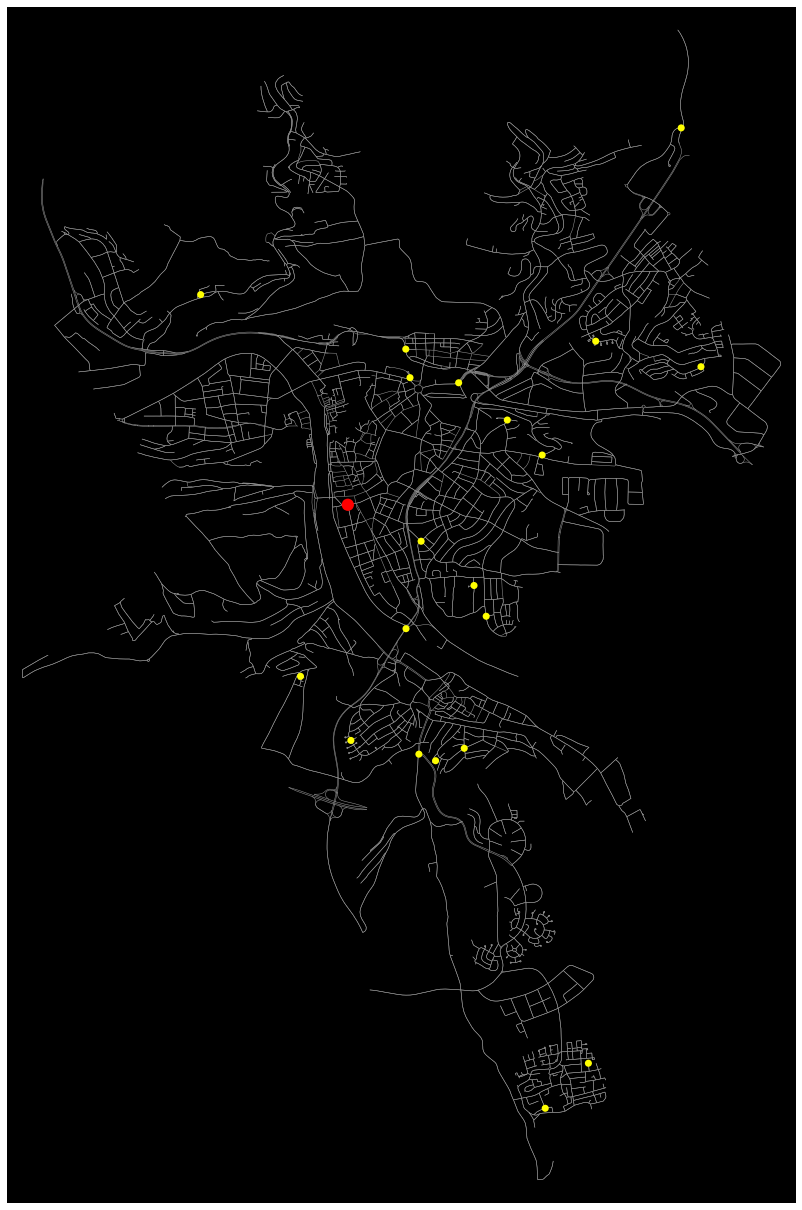

In [28]:
# First show the potential DCs and Customers
#warnings.filterwarnings("ignore")

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")


nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

ns = []
for node in G.nodes():
    if node in DC_S:
        ns.append(150)
    elif node in Nodes_S:
        ns.append(50)
    else:
        ns.append(0)
        
nc = []
for node in G.nodes():
    if node in DC_S: 
        nc.append("red")
    elif node in Nodes_S:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [ ]:
test teste test test test te

In [38]:
# Stop Counter
for k in K:
    r_c = sum([x[i,j,k].X for i in [*I,*J] for j in [*I,*J]])
    print(" Vehicle {} has {} stops on its route".format(k, r_c))

 Vehicle V_1 has 11.0 stops on its route
 Vehicle V_2 has 10.0 stops on its route
 Vehicle V_3 has 7.0 stops on its route


In [39]:
# Router Order Printer: This one works DC1 (DC has to be hardcoded)
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC1", "*", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC1"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC1":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC1")
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k))  

Route for Vehicle V_3: DC1 -> C10 -> C7 -> C4 -> C6 -> C9 -> C1 -> DC1
Total Distance 37713.4m for Vehicle V_1
Total Distance 30476.2m for Vehicle V_2
Total Distance 13169.1m for Vehicle V_3


In [30]:
# This one works DC2, have to hardcode the DC
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC2", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC2"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC2":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC2")
    
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k))     

Route for Vehicle V_2: DC2 -> C2 -> C17 -> C19 -> C18 -> C8 -> C15 -> C25 -> C14 -> C20 -> DC2
Route for Vehicle V_1: DC2 -> C5 -> C11 -> C24 -> C13 -> C3 -> C23 -> C16 -> C12 -> C22 -> C21 -> DC2
Total Distance 37713.4m for Vehicle V_1
Total Distance 30476.2m for Vehicle V_2
Total Distance 13169.1m for Vehicle V_3


In [32]:
# This one works DC3, have to hardcode the DC
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC3", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC3"), end = "")
    next_stop = tup[1]
    while next_stop:
        if next_stop == "DC3":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop = selected.select(next_stop, "*")[0][1]
    print(" -> DC3")
    
# Total Distances of the routes of each vehicle (includes vehicle that does not start from this DC)
for k in K:
    r_len = sum([x[i,j,k].X  * dist_matrix_d.loc[i,j] for i in [*I,*J] for j in [*I,*J]]) 
    print("Total Distance {}m for Vehicle {}".format(r_len.round(1), k)) 

Total Distance 26311.6m for Vehicle V_1
Total Distance 22711.9m for Vehicle V_2
Total Distance 14062.2m for Vehicle V_3


In [ ]:
distList = dist_matrix_d.values.tolist()
distList

In [320]:
distList = dist_matrix_d.values.tolist()
dist_slices = tuple(slice(x) for x in distList)
dist_slice = data[dist_slices]
dist_slice

NameError: name 'data' is not defined

In [ ]:
dist_slices

In [322]:
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)
for i, tup in enumerate(selected.select("DC3", "*")):
    k = tup[2]
    print("Route for Vehicle {}: {}".format(k, "DC3"), end = "")
    next_stop = tup[1]
    vehicle_dist = distList[0][next_stop]
    while next_stop:
        if next_stop == "DC3":
            break
        else:
            print(" -> {}".format(next_stop), end="")
            next_stop1 = selected.select(next_stop, "*")[0][1]
            vehicle_dist += distList[next_stop][next_stop1]
            print("Route Distance {}".format(vehicle_dist))
    print(" -> DC3")

Route for Vehicle V_3: DC3

TypeError: list indices must be integers or slices, not str

In [33]:
# Try to automate routing
# build dataframe which has all the osmids for DCs and Customers
# Join this dataframe with the list of tuples for the routes
vals = m.getAttr('X', x)
selected = tuplelist((i, j, k) for i, j, k in vals.keys() if vals[i, j, k] > 0.5)

In [34]:
dc_set = set_of_all_DC.reset_index(level = "DC_ID")
dc_set.drop(["fixed_cost_DC", "capacity_DC", "varCost_DC", "lat", "lon"], axis=1, inplace=True)
dc_set.rename(columns={"DC_ID": "ID"}, inplace=True)
dc_set

,ID,osmid
0,DC1,27489160


In [35]:
c_set = set_of_all_customers.reset_index(level = "C_ID")
c_set.drop(["Demand_C", "lat", "lon"], axis=1, inplace=True)
c_set.rename(columns={"C_ID": "ID"}, inplace=True)
c_set.head()

,ID,osmid
0,C1,10799942
1,C2,29761352
2,C3,29877216
3,C4,30255680
4,C5,33174128


In [36]:
set_join = pd.concat([dc_set, c_set], axis=0)
set_join.head()

,ID,osmid
0,DC1,27489160
0,C1,10799942
1,C2,29761352
2,C3,29877216
3,C4,30255680


In [37]:
tuplol = list(selected)
mydf = pd.DataFrame(tuplol)

In [38]:
mydf.rename(columns={0: "Orig", 1: "Dest", 2: "V"}, inplace=True)
mydf.head()

,Orig,Dest,V
0,DC1,C1,V_1
1,DC1,C8,V_3
2,DC1,C18,V_2
3,C1,C13,V_1
4,C2,C10,V_2


In [39]:
joiner = pd.merge(mydf, set_join, left_on = "Orig", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "orig_osmid"}, inplace=True)
joiner = pd.merge(joiner, set_join, left_on = "Dest", right_on = "ID")
joiner.drop(["ID"], axis=1, inplace=True)
joiner.rename(columns={"osmid": "dest_osmid"}, inplace=True)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid
0,DC1,C1,V_1,27489160,10799942
1,DC1,C8,V_3,27489160,42411314
2,DC1,C18,V_2,27489160,5301313588
3,C1,C13,V_1,10799942,280991147
4,C2,C10,V_2,29761352,101458357


In [40]:
def shortest_route(orig, dest):
    route = nx.shortest_path(Gs, source=orig, target=dest, weight= "length")                                 
    return route

In [41]:
joiner["route"] = joiner.apply(lambda x: shortest_route(x["orig_osmid"], x["dest_osmid"]), axis=1)
joiner.head()

,Orig,Dest,V,orig_osmid,dest_osmid,route
0,DC1,C1,V_1,27489160,10799942,"[27489160, 27489167, 27489444, 27489166, 27489..."
1,DC1,C8,V_3,27489160,42411314,"[27489160, 21273732, 21273701, 28807354, 83734..."
2,DC1,C18,V_2,27489160,5301313588,"[27489160, 21273732, 21273701, 28099571, 21273..."
3,C1,C13,V_1,10799942,280991147,"[10799942, 10799945, 27271153, 27471744, 25584..."
4,C2,C10,V_2,29761352,101458357,"[29761352, 29761354, 332606657, 29761357, 3326..."


In [42]:
# All of the Routes / no distinction between vehicles
route_list = joiner["route"].tolist()

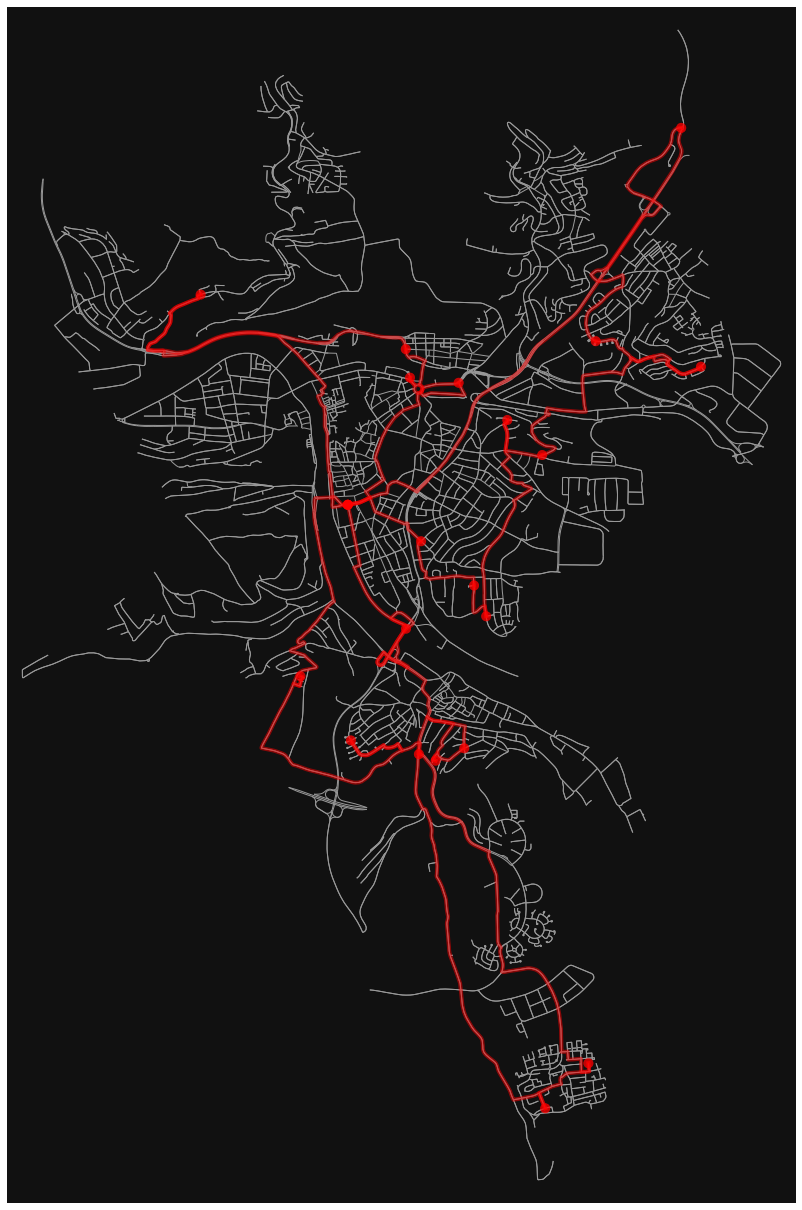

In [43]:
fig, ax = ox.plot_graph_routes(G, 
                               route_list, 
                               route_linewidth = 3, node_size = 0, figsize=(22,22))

In [44]:
# Have to split the routes into vehicles, this is for vehicle 1
v1 = joiner[joiner["V"]=="V_1"]
v1_routes = v1["route"].tolist()
len(v1_routes)

9

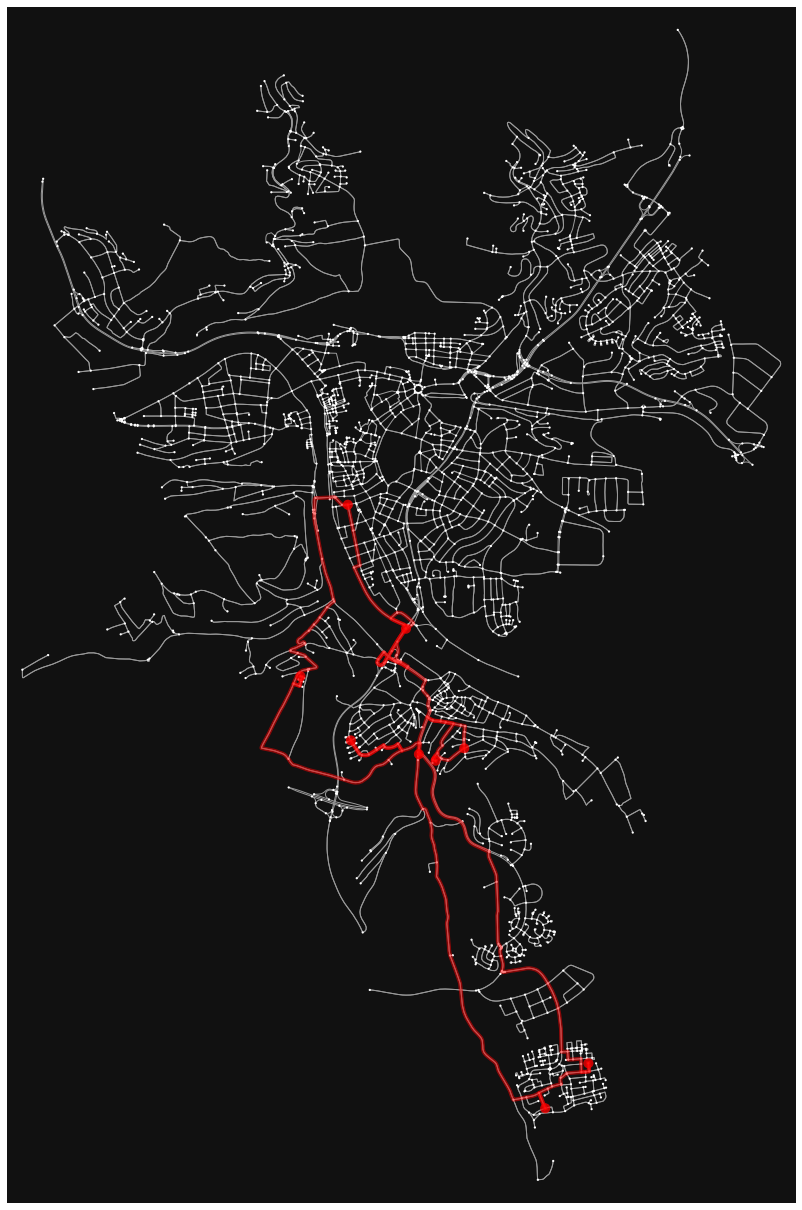

In [45]:
fig, ax = ox.plot_graph_routes(G, 
                               routes =v1_routes, route_color =["red"], # Vehicle 1 Yellows, V2 Red
                               route_linewidth= 4, node_size = 5, figsize=(22,22))

In [46]:
# To do further customization with node sizes/colors etc we need a list of all the nodes a Vehicle visits
v2 = joiner[joiner["V"]=="V_1"]
v2_routes = v2["route"].tolist()

In [47]:
v2_nodes_o= v2["orig_osmid"].tolist()
v2_nodes_d= v2["dest_osmid"].tolist()
v2_nodes = v2_nodes_o + v2_nodes_d
#v2_nodes

In [48]:
# Since the list always start with the DC, we can use loc[0] as condition for size increase when plotting
ns = []
for node in G.nodes():
    if node == v2_nodes[0]:
        ns.append(500)
    else:
        ns.append(0)

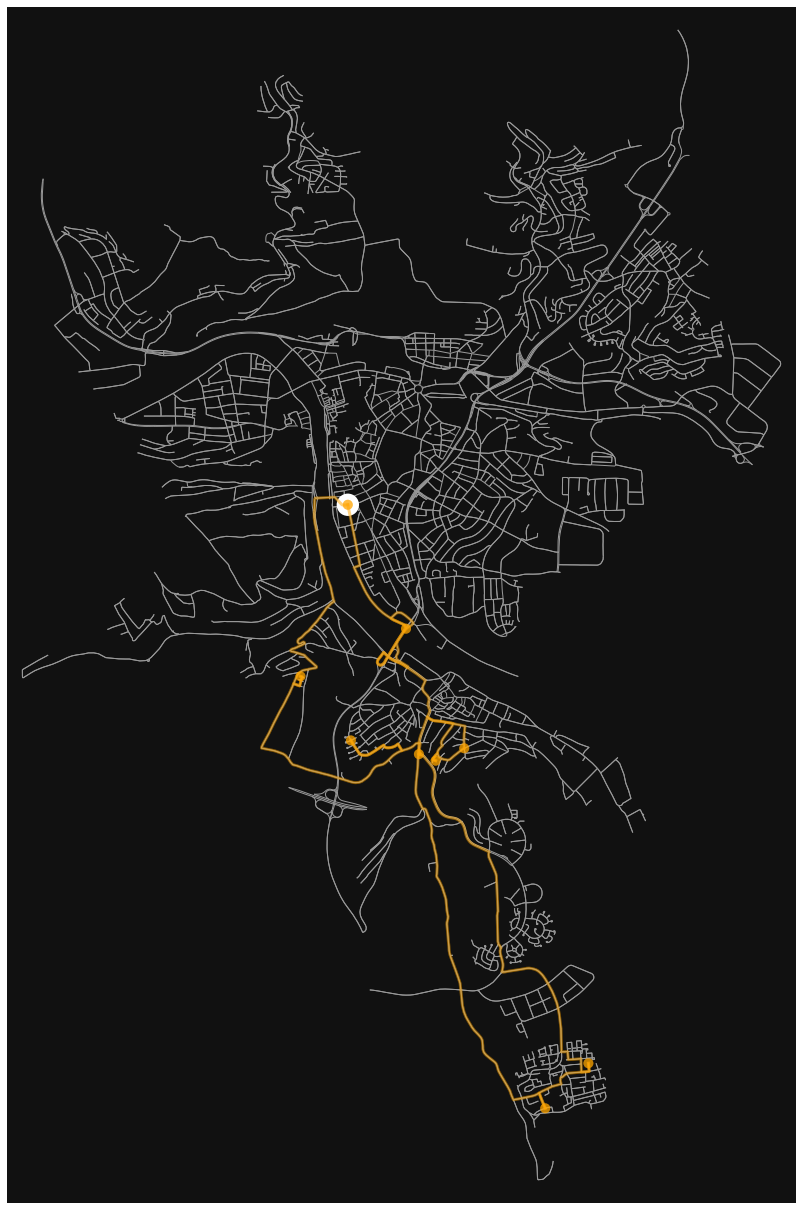

In [49]:
fig, ax = ox.plot_graph_routes(G, 
                               v2_routes, route_colors = "orange", route_linewidths = 3, node_size=ns,
                                  figsize=(22,22))

<font size =6>**Sanity Check / OLD**</font>

In [122]:
# Check if the distances are correct - Example DC1 / DC2. Have different lengths DC1-DC2 / DC2-DC1. 
route1 = ox.shortest_path(Gs, 27489160, 30747843, weight= "length")
route2 = ox.shortest_path(Gs, 30747843, 27489160, weight= "length")
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(Gs, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(Gs, route2, "length")))
print("Route 1 is", route1_length, "meters.")
print("Route 2 is", route2_length, "meters.")

Route 1 is 2426 meters.
Route 2 is 2123 meters.


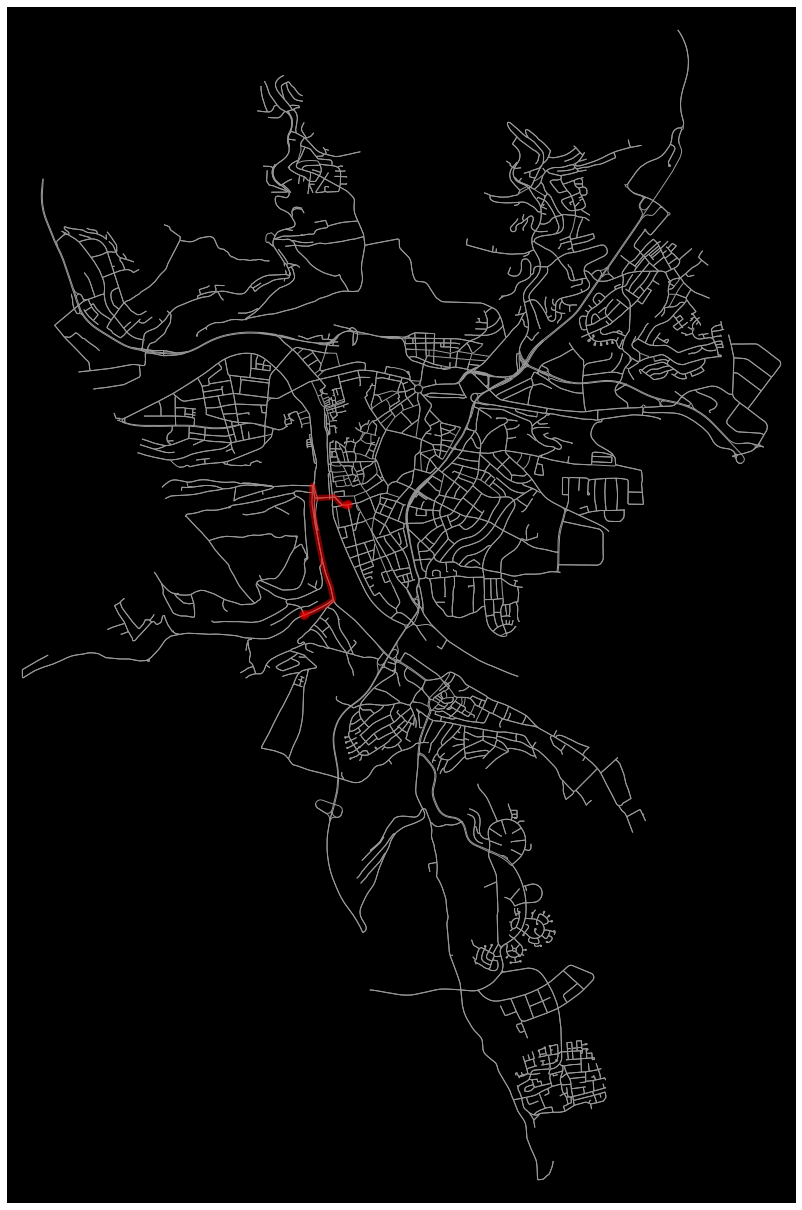

In [40]:
## Plot the route
ox.plot_graph_route(Gs, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize= (22,22));

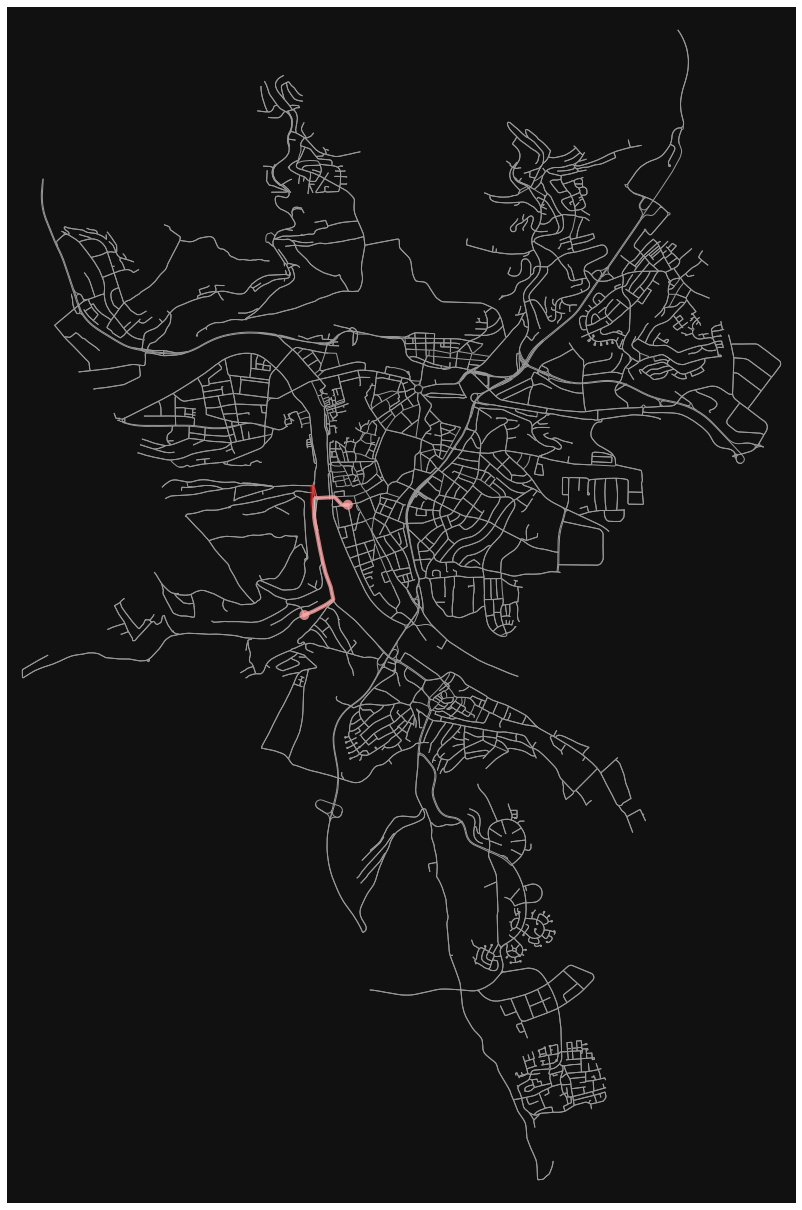

In [41]:
# Makes sense, irl you have to do the same when driving over this bridge
fig, ax = ox.plot_graph_routes(
    Gs, routes =[route1, route2], route_colors =["red", "white"], route_linewidth= 4, node_size = 0, figsize=(22,22)
)

<font size =6>**OLD**</font>

In [ ]:
# # old route printer with route length for each
print("The following Routes have to be driven to satisfy all demand:")
for i in [*I,*J]:
    for j in [*I,*J]:
        for k in K:
            if x[i,j,k].X >= 0.1:
                print("From {} to {} in Vehicle {} for length {}m".format(i,j,k, dist_matrix.loc[i,j])) 

In [24]:
place = {"city": "Albstadt", "country":"Germany"}
G = ox.graph_from_place(place, network_type = "drive")
G = ox.utils_graph.get_largest_component(G, strongly = True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
49.785592, 9.930666 
49.773391, 9.923226
49.800460, 9.951607
49.811422,9.981127
49.791321 , 9.953342

27489160, 30747843, 40430241, 27352149, 27457548

route1 = ox.shortest_path(F, depot, drop1, weight= "travel_time")
route2 = ox.shortest_path(F, drop1, drop2, weight= "travel_time")
route3 = ox.shortest_path(F, drop2, drop3, weight= "travel_time")
route4= ox.shortest_path(F, drop3, depot2, weight= "travel_time")

route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route2, "travel_time")))
route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route3, "travel_time")))
route4_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route4, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")
print("Route 3 is", route3_length, "meters and takes", route3_time, "seconds.")
print("Route 4 is", route4_length, "meters and takes", route4_time, "seconds.")

In [22]:
def route_timer(orig, dest):
    route = ox.shortest_path(G, orig, dest, weight = "travel_time")
    route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, "travel_time")))
    return route_time

In [23]:
route_timer(27489160, 30747843)

217

In [25]:
route_timer(290847730,366360585)

382

In [ ]:
Albstadt
#-290847730; Coordinates: 48.2554692, 9.0136856
#-366360585; Coordinates: 48.2110663, 9.022576
#-293003525; Coordinates: 48.2304419, 8.9677358
#-248746221; Coordinates: 48.237164, 9.027823
#-262388012; Coordinates: 48.222982, 8.9184284

In [6]:
a = [27489160, 30747843, 40430241, 27352149, 27457548]
b = [27489160, 30747843, 40430241, 27352149, 27457548]

In [7]:
router(a,b)

[[27489160], [30747843], [40430241], [27352149], [27457548]]

In [ ]:
lambda x: router(x

In [ ]:
lrp.DC_Print()
lrp.Route_Counter()
lrp.Route_DC(DC= "DC1")
lrp.Route_Distance()
lrp.Cost_Printer()
lrp.cost_df.to_csv("model_results/first_cost_df")
lrp.cost_df
lrp.Basic_Plot()
lrp.Route_Plot(Vehicle = "V_1")
lrp.Route_Plot(Vehicle = "V_2")
lrp.Route_Plot(Vehicle = "V_3")